In [1]:
import pandas as pd
import numpy as np
import sys
import os
import gensim
import spacy
import altair as alt
from hyphen import Hyphenator
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS 
from gensim.parsing.preprocessing import strip_tags
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_numeric
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from sklearn.metrics import accuracy_score
import textstat
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics 
nltk.download('averaged_perceptron_tagger')
cwd = os.getcwd()
from sklearn.svm import SVC
from operator import itemgetter
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
import operator

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\afhar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : db08276bc116c438d3fdee492026f8223584c477
python           : 3.7.9.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : AMD64 Family 23 Model 113 Stepping 0, AuthenticAMD
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 1.1.3
numpy            : 1.17.0
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 20.2.4
setuptools       : 50.3.1.post20201107
Cython           : 0.29.21
pytest           : 6.1.1
hypothesis       : None
sphinx           : 3.2.1
blosc            : None
feather          : None
xlsxwriter       : 1.3.7
lxml.etree       : 4.6.1
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.19.0
pandas_datareader: None
bs4              : 4.9.3
bottleneck       : 1.3.2
fsspe

In [2]:
prep2 = pd.read_pickle('brosko_train_f.pkl')
df_tokenized = pd.read_pickle('df_tokenized')
p_list = ['nouns','verbs', 'Pnouns', 'adjectives', 'adverbs']
for p in p_list:
    col = p + '_%'
    df_tokenized[col] = df_tokenized[p].astype(float)/df_tokenized['num_words'].astype(float)
merged = df_tokenized.merge(prep2, left_index=True, right_index=True, how='inner')

In [3]:
merged.columns

Index(['original_text_x', 'label_x', 'tokens', 'pos', 'nouns', 'verbs',
       'Pnouns', 'adjectives', 'adverbs', 'num_words', 'syls', 'max_syls',
       'avg_syls', 'std_syls', 'flesch_score', 'flesch_grade_lvl',
       'fog_grade_lvl', 'ARI_grade', 'CLI_grade', 'LWF_grade',
       'Dale-Chall_score', 'combined_grade', 'nouns_%', 'verbs_%', 'Pnouns_%',
       'adjectives_%', 'adverbs_%', 'index', 'original_text_y', 'label_y',
       'clean_text', 'word_count', 'clean_text_no_stop', 'word_count_no_stop',
       'Nsyll', 'AoA_Kup_lem', 'Perc_known_lem'],
      dtype='object')

In [3]:
#define the features and scale the data
cols = ['nouns', 'verbs',
        'Pnouns', 'adjectives', 'adverbs', 'num_words', 'max_syls',
        'nouns_%', 'verbs_%', 'Pnouns_%','adjectives_%', 'adverbs_%',
        'avg_syls', 'std_syls', 'flesch_score', 'flesch_grade_lvl',
        'fog_grade_lvl', 'ARI_grade', 'CLI_grade', 'LWF_grade',
        'Dale-Chall_score','word_count_no_stop','Nsyll','AoA_Kup_lem','Perc_known_lem']
X_train = merged[cols]
#X_train = merged[['flesch_score', 'flesch_grade_lvl',
#       'fog_grade_lvl', 'ARI_grade', 'CLI_grade', 'LWF_grade',
#       'Dale-Chall_score']]
X_train = X_train.replace(np.nan, 0)
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
y_train = merged['label_x'].values

In [4]:
#Split the data
X= X_train
y = y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train_df = pd.DataFrame(X_train, columns = cols)
X_test_df = pd.DataFrame(X_test, columns = cols)

In [5]:
#feature selection tests
rf = RandomForestClassifier(n_estimators=100, max_depth = 16, max_features = None)
rf.fit(X_train[:50000], y_train[:50000])
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6848342955196534

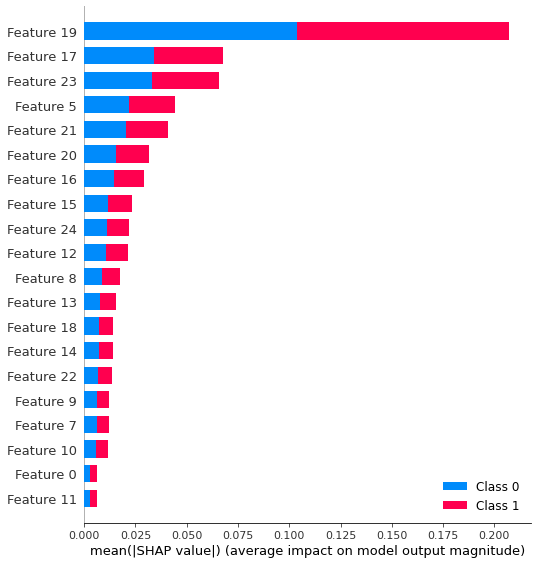

In [6]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_train[:500])
shap.summary_plot(shap_values, X_train[:500], plot_type="bar")

AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!

In [11]:
#Train the model
estimator_RF = RandomForestClassifier()
params = {
    'n_estimators':[10,50,100,200],
    'max_depth': [5,10,16,20],

}
#use grid search for tuning
grid_search_RF = GridSearchCV(
    estimator=estimator_RF,
    param_grid=params,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose=3
)


In [12]:
#develop a couple different feature sets
X_train_1 = X_train_df.values #full
X_train_2 = X_train_df[['flesch_score', 'flesch_grade_lvl','fog_grade_lvl', 'ARI_grade', 'CLI_grade', 'LWF_grade','Dale-Chall_score']].values #just other scorers
X_train_3 = X_train_df[['num_words', 'max_syls','nouns_%', 'verbs_%', 'Pnouns_%','adjectives_%', 'adverbs_%','avg_syls', 'std_syls','AoA_Kup_lem','Perc_known_lem']].values #just text stats
X_train_4 = X_train_df[['AoA_Kup_lem','Perc_known_lem','word_count_no_stop' ]].values #basic model

X_test_1 = X_test_df.values #full
X_test_2 = X_test_df[['flesch_score', 'flesch_grade_lvl','fog_grade_lvl', 'ARI_grade', 'CLI_grade', 'LWF_grade','Dale-Chall_score']].values #just other scorers
X_test_3 = X_test_df[['num_words', 'max_syls','nouns_%', 'verbs_%', 'Pnouns_%','adjectives_%', 'adverbs_%','avg_syls', 'std_syls','AoA_Kup_lem','Perc_known_lem']].values #just text stats
X_test_4 = X_test_df[['AoA_Kup_lem','Perc_known_lem','word_count_no_stop' ]].values #basic model

#Do the search
RF_1=grid_search_RF.fit(X_train_1[:5000], y_train[:5000]) #full feature list
y_pred_RF =RF_1.predict(X_test_1[:5000])
print('1 done')
RF_2=grid_search_RF.fit(X_train_2[:5000], y_train[:5000]) #just other scoring methodsI w
y_pred_RF2 =RF_2.predict(X_test_2[:5000])
print('2 done')
RF_3=grid_search_RF.fit(X_train_3[:5000], y_train[:5000]) #just text stats
y_pred_RF3 =RF_3.predict(X_test_3[:5000])
print('3 done')
RF_4=grid_search_RF.fit(X_train_4[:5000], y_train[:5000]) #basic model, probably likes starbucks and uggs
y_pred_RF4 =RF_4.predict(X_test_4[:5000])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.0s finished


1 done
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 out of  80 | elapsed:    1.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


2 done
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  49 out of  80 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.3s finished


3 done
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 out of  80 | elapsed:    0.8s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.1s finished


In [ ]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [12]:
#Parameter setting that gave the best results on the hold out data.
print(grid_search_SVM.best_params_ ) 
#Mean cross-validated score of the best_estimator
print('Best Score - SVM:', grid_search_SVM.best_score_ )

{'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l1'}
Best Score - SVM: 0.6270547390337075


In [10]:
print('Best Score - KNN:', KNN_1.best_score_ )

Best Score - KNN: 0.6684393827485577


In [15]:
#check with the hold out data
print('Accuracy Score - SVM - 1:', metrics.accuracy_score(y_test[:5000], y_pred_RF)) 
print('Accuracy Score - SVM - 2:', metrics.accuracy_score(y_test[:5000], y_pred_RF2)) 
print('Accuracy Score - SVM - 3:', metrics.accuracy_score(y_test[:5000], y_pred_RF3)) 
print('Accuracy Score - SVM - 4:', metrics.accuracy_score(y_test[:5000], y_pred_RF4)) 

Accuracy Score - SVM - 1: 0.6694
Accuracy Score - SVM - 2: 0.6486
Accuracy Score - SVM - 3: 0.6472
Accuracy Score - SVM - 4: 0.6426


In [36]:
#prepare the actual test data for submission
submit_df = pd.read_pickle('test_data.pkl')
p_list = ['nouns','verbs', 'Pnouns', 'adjectives', 'adverbs']
for p in p_list:
    col = p + '_%'
    submit_df[col] = submit_df[p].astype(float)/submit_df['num_words'].astype(float)
submit_df = submit_df.replace(np.nan, 0)
submit_s = scaler.transform(submit_df[cols])
submit = pd.DataFrame(submit_s, columns = cols)
X_sub_1 = submit.values #full
X_sub_2 = submit[['flesch_score', 'flesch_grade_lvl','fog_grade_lvl', 'ARI_grade', 'CLI_grade', 'LWF_grade','Dale-Chall_score']].values #just other scorers
X_sub_3 = submit[['num_words', 'max_syls','nouns_%', 'verbs_%', 'Pnouns_%','adjectives_%', 'adverbs_%','avg_syls', 'std_syls','AoA_Kup_lem','Perc_known_lem']].values #just text stats
X_sub_4 = submit[['AoA_Kup_lem','Perc_known_lem','word_count_no_stop' ]].values #basic model



In [40]:
#train the best model
knn_f = KNeighborsClassifier(leaf_size= 20, metric= 'chebyshev', n_neighbors=1000, p= 1, weights= 'distance') #start with square root of N, to add a loop later
knn_f.fit(X_train_1, y_train)
y_pred = knn_f.predict(X_sub_1)
df = pd.DataFrame()
df['id'] =submit_df.index
df['label'] = y_pred
df.to_csv('knn_textscores_only.csv',index = False)
# 0.71537 on kaggle! passing

In [44]:
#train the best "small" model
knn_f_s = KNeighborsClassifier(leaf_size= 20, metric= 'chebyshev', n_neighbors=1000, p= 1, weights= 'distance') #start with square root of N, to add a loop later
knn_f_s.fit(X_train_2, y_train)
y_pred = knn_f_s.predict(X_sub_2)
df = pd.DataFrame()
df['id'] =submit_df.index
df['label'] = y_pred
df.to_csv('knn_textscores_only.csv',index = False)
#0.70100, barely worse

In [37]:
y_pred = KNN_1.predict(X_sub_4)
df = pd.DataFrame()
df['id'] =submit_df.index
df['label'] = y_pred
df.to_csv('knn_textscores_only.csv',index = False)

In [43]:
X_sub_2.shape

(119092, 7)